#Installing Requirements

In [ ]:
!pip install --upgrade pip

In [ ]:
# Install the required packages
!pip install numpy pandas pydicom scikit-image imageio pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

In [ ]:
!pip install monai torch torchvision nibabel tqdm


In [ ]:
# Install the required packages
!pip install numpy pandas pydicom scikit-image imageio pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

#DICOM Functions

In [ ]:
from typing import AnyStr, BinaryIO, Dict, List, NamedTuple, Optional, Union
import numpy as np
import pandas as pd
import pydicom as dicom
from skimage.exposure import rescale_intensity
import imageio

def dcmread_image(fp: Union[str, os.PathLike[AnyStr], BinaryIO], view: str, index: Optional[np.uint] = None) -> np.ndarray:
    """Read pixel array from DBT DICOM file."""
    ds = dicom.dcmread(fp)
    ds.decompress(handler_name="pylibjpeg")  # Use pylibjpeg for decompression
    pixel_array = ds.pixel_array
    view_laterality = view[0].upper()
    image_laterality = _get_image_laterality(pixel_array[index or 0])

    if index is not None:
        pixel_array = pixel_array[index]

    if not image_laterality == view_laterality:
        pixel_array = np.flip(pixel_array, axis=(-1, -2))

    window_center = _get_window_center(ds)
    window_width = _get_window_width(ds)
    low = (2 * window_center - window_width) / 2
    high = (2 * window_center + window_width) / 2
    pixel_array = rescale_intensity(pixel_array, in_range=(low, high), out_range="dtype")

    return pixel_array

def read_boxes(boxes_fp: str, filepaths_fp: str) -> pd.DataFrame:
    """Read pandas DataFrame with bounding boxes joined with file paths."""
    df_boxes = pd.read_csv(boxes_fp)
    df_filepaths = pd.read_csv(filepaths_fp)
    primary_key = ("PatientID", "StudyUID", "View")
        if not all([key in df_boxes.columns for key in primary_key]):
        raise AssertionError(f"Not all primary key columns {primary_key} are present in bounding boxes columns {df_boxes.columns}")

    if not all([key in df_filepaths.columns for key in primary_key]):
        raise AssertionError(f"Not all primary key columns {primary_key} are present in file paths columns {df_filepaths.columns}")

    return pd.merge(df_boxes, df_filepaths, on=primary_key)

def draw_box(image: np.ndarray, x: int, y: int, width: int, height: int, color: Optional[Union[int, tuple]] = None, lw=4) -> np.ndarray:
    """Draw bounding box on the image."""
    x = min(max(x, 0), image.shape[1] - 1)
    y = min(max(y, 0), image.shape[0] - 1)

    if color is None:
        color = 255

    if len(image.shape) > 2 and not hasattr(color, "__len__"):
        color = (color,) + (0,) * (image.shape[-1] - 1)

    image[y : y + lw, x : x + width] = color
    image[y + height - lw : y + height, x : x + width] = color
    image[y : y + height, x : x + lw] = color
    image[y : y + height, x + width - lw : x + width] = color

    return image

def evaluate(labels_fp: str, boxes_fp: str, predictions_fp: str) -> Dict[str, float]:
    """Evaluate predictions."""
    df_labels = pd.read_csv(labels_fp)
    df_boxes = pd.read_csv(boxes_fp, dtype={"VolumeSlices": float})
    df_pred = pd.read_csv(predictions_fp, dtype={"Score": float})

    df_labels = df_labels.reset_index().set_index(["StudyUID", "View"]).sort_index()
    df_boxes = df_boxes.reset_index().set_index(["StudyUID", "View"]).sort_index()
    df_pred = df_pred.reset_index().set_index(["StudyUID", "View"]).sort_index()

    df_pred["TP"] = 0
    df_pred["GTID"] = -1

    thresholds = [df_pred["Score"].max() + 1.0]

    for box_pred in df_pred.itertuples():
        if box_pred.Index not in df_boxes.index:
            continue

        df_boxes_view = df_boxes.loc[[box_pred.Index]]
        view_slice_offset = df_boxes.loc[[box_pred.Index], "VolumeSlices"].iloc[0] / 4
        tp_boxes = [b for b in df_boxes_view.itertuples() if _is_tp(box_pred, b, slice_offset=view_slice_offset)]

        if len(tp_boxes) > 1:
            tp_distances = [_distance(box_pred, b) for b in tp_boxes]
            tp_boxes = [tp_boxes[np.argmin(tp_distances)]]

        if len(tp_boxes) > 0:
            tp_i = tp_boxes[0].index
            df_pred.loc[df_pred["index"] == box_pred.index, ("TP", "GTID")] = (1, tp_i)
            thresholds.append(box_pred.Score)

    thresholds.append(df_pred["Score"].min() - 1.0)

    evaluation_fps_all = (2.0,)
    tpr_all = _froc(df_pred=df_pred, thresholds=thresholds, n_volumes=len(df_labels), n_boxes=len(df_boxes), evaluation_fps=evaluation_fps_all)
    result = {f"sensitivity_at_2_fps_all": tpr_all[0]}

    df_pred = df_pred[df_pred.index.isin(df_boxes.index)]
    df_labels = df_labels[df_labels.index.isin(df_boxes.index)]
    evaluation_fps_positive = (1.0, 2.0, 3.0, 4.0)
    tpr_positive = _froc(df_pred=df_pred, thresholds=thresholds, n_volumes=len(df_labels), n_boxes=len(df_boxes), evaluation_fps=evaluation_fps_positive)

    result.update(dict((f"sensitivity_at_{int(x)}_fps_positive", y) for x, y in zip(evaluation_fps_positive, tpr_positive)))
    result.update({"mean_sensitivity_positive": np.mean(tpr_positive)})

    return result

def _froc(df_pred: pd.DataFrame, thresholds: List[float], n_volumes: int, n_boxes: int, evaluation_fps: tuple) -> List[float]:
    """Free-response receiver operating characteristic (FROC) calculation."""
    tpr = []
    fps = []

    for th in sorted(thresholds, reverse=True):
        df_th = df_pred.loc[df_pred["Score"] >= th]
        df_th_unique_tp = df_th.reset_index().drop_duplicates(subset=["StudyUID", "View", "TP", "GTID"])
        n_tps_th = float(sum(df_th_unique_tp["TP"]))
        tpr_th = n_tps_th / n_boxes
        n_fps_th = float(len(df_th[df_th["TP"] == 0]))
        fps_th = n_fps_th / n_volumes
        tpr.append(tpr_th)
        fps.append(fps_th)

        if fps_th > max(evaluation_fps):
            break

    return [np.interp(x, fps, tpr) for x in evaluation_fps]

def _is_tp(box_pred: NamedTuple, box_true: NamedTuple, slice_offset: int, min_dist: int = 100) -> bool:
    """Determine if a prediction is a true positive."""
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z + box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice

    dist = np.linalg.norm((pred_x - true_x, pred_y - true_y))
    dist_threshold = np.sqrt(box_true.Width ** 2 + box_true.Height ** 2) / 2.0
    dist_threshold = max(dist_threshold, min_dist)
    slice_diff = np.abs(pred_z - true_z)

    return dist <= dist_threshold and slice_diff <= slice_offset

def _distance(box_pred: NamedTuple, box_true: NamedTuple) -> float:
    """Calculate the Euclidean distance between predicted and true box centers."""
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z + box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice

    return np.linalg.norm((pred_x - true_x, pred_y - true_y, pred_z - true_z))

def _get_dicom_laterality(ds: dicom.dataset.FileDataset) -> str:
    """Get laterality from DICOM metadata (unreliable)."""
    return ds[0x5200, 0x9229][0][0x0020, 0x9071][0][0x0020, 0x9072].value

def _get_image_laterality(pixel_array: np.ndarray) -> str:
    """Determine laterality based on image pixel intensity."""
    left_edge = np.sum(pixel_array[:, 0])  # sum of left edge pixels
    right_edge = np.sum(pixel_array[:, -1])  # sum of right edge pixels
    return "R" if left_edge < right_edge else "L"

def _get_window_center(ds: dicom.dataset.FileDataset) -> np.float32:
    """Get window center from DICOM metadata."""
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1050].value)

def _get_window_width(ds: dicom.dataset.FileDataset) -> np.float32:
    """Get window width from DICOM metadata."""
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1051].value)



#Processing DICOM Files

In [ ]:
import os

def process_dicom_files(dicom_files: List[str], boxes_csv_path: str, filepaths_csv_path: str, labels_csv_path: str, predictions_csv_path: str):
    # Read bounding boxes and file paths
    df = read_boxes(boxes_csv_path, filepaths_csv_path)

    for dicom_file_path in dicom_files:
        # Extract the view from the file path or use a default view
        view = 'LCC'  # Example view; adjust as needed

        # Read and process the DICOM file
        image_array = dcmread_image(dicom_file_path, view)

        # Draw a bounding box on the image (example coordinates)
        x, y, width, height = 50, 50, 100, 100  # Replace with actual coordinates if available
        image_with_box = draw_box(image_array, x, y, width, height)

        # Save the image with the bounding box
        output_image_path = os.path.splitext(dicom_file_path)[0] + '_output.png'
        imageio.imwrite(output_image_path, image_with_box)

        # Evaluate predictions
        if labels_csv_path and predictions_csv_path:
            evaluation_results = evaluate(labels_csv_path, boxes_csv_path, predictions_csv_path)
            print(f"Evaluation results for {dicom_file_path}: {evaluation_results}")

# Define file paths
boxes_csv_path = '/content/Breast-Cancer-Screening-DBT/boxes.csv'
filepaths_csv_path = '/content/Breast-Cancer-Screening-DBT/filepaths.csv'
labels_csv_path = '/content/Breast-Cancer-Screening-DBT/labels.csv'
predictions_csv_path = '/content/Breast-Cancer-Screening-DBT/predictions.csv'

# Process the DICOM files
process_dicom_files(dicom_files, boxes_csv_path, filepaths_csv_path, labels_csv_path, predictions_csv_path)


#Unzipping and Combining

In [ ]:
# @title
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the function to combine and extract ZIP files
import zipfile
import os
from typing import List

def combine_and_extract_zip_files(zip_files: List[str], extract_to: str) -> List[str]:
    """
    Extract multiple ZIP files into a single directory.
    Collect all DICOM file paths from the extracted directories.

    Parameters:
    - zip_files: List of ZIP file paths to be extracted.
    - extract_to: Directory where the ZIP files will be extracted.

    Returns:
    - List of all DICOM file paths.
    """
    all_dicom_files = []

    # Extract each ZIP file
    for zip_file in zip_files:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

    # Collect all DICOM files from the extracted directories
    for subdir, _, files in os.walk(extract_to):
        for file in files:
            if file.lower().endswith('.dcm'):
                all_dicom_files.append(os.path.join(subdir, file))

    return all_dicom_files


# Define the directory to extract the ZIP files to
extract_to = '/content/dataset/'

# List of ZIP file paths on Google Drive
zip_file_paths = [
    '/content/drive/MyDrive/Praktikum/Breast-Cancer-Screening-DBT_before4000.zip',
    '/content/drive/MyDrive/Praktikum/Breast-Cancer-Screening-DBT.zip'
]

# Combine and extract the ZIP files, and collect all DICOM file paths
dicom_files = combine_and_extract_zip_files(zip_file_paths, extract_to)

# Print the number of DICOM files found
print(f"Found {len(dicom_files)} DICOM files.")



#3D Patching

In [ ]:
import os
import pydicom
import numpy as np
import pandas as pd
from skimage.exposure import rescale_intensity
import nibabel as nib
from tqdm import tqdm
import gc
from typing import List

def load_dicom_volume(dicom_file):
    ds = pydicom.dcmread(dicom_file)
    volume = ds.pixel_array
    volume = rescale_intensity(volume, out_range=(0, 255)).astype(np.uint8)
    return volume

def get_patient_and_study_id(dicom_file_path):
    """
    Extract Patient ID and Study ID from a DICOM file.

    Parameters:
    - dicom_file_path: Path to the DICOM file.

    Returns:
    - patient_id: The Patient ID extracted from the DICOM file.
    - study_uid: The Study ID extracted from the DICOM file.
    """
    ds = pydicom.dcmread(dicom_file_path)
    patient_id = ds.PatientID
    study_uid = ds.StudyInstanceUID
    return patient_id, study_uid

def collect_dicom_files(root_dir: str) -> List[str]:
    """Collect all DICOM file paths from the directory structure."""
    dicom_files = []
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith('.dcm'):
                dicom_files.append(os.path.join(subdir, file))
    return dicom_files

def save_slices_based_on_csv(csv_path, dicom_files, save_dir):
    # Load the CSV file
    csv_data = pd.read_csv(csv_path)

    # Create a DataFrame to save metadata
    df = pd.DataFrame(columns=['PatientID', 'StudyUID', 'view', 'img_path', 'Normal', 'Actionable', 'Benign', 'Cancer'])

    os.makedirs(save_dir, exist_ok=True)

    for dicom_file in tqdm(dicom_files):
        try:
            patient_id, study_uid = get_patient_and_study_id(dicom_file)
            matching_rows = csv_data[(csv_data['PatientID'] == patient_id)]

            if not matching_rows.empty:
                volume = load_dicom_volume(dicom_file)

                for _, row in matching_rows.iterrows():
                    view = row['View']
                    x = row['X']
                    y = row['Y']
                    width = row['Width']
                    height = row['Height']
                    slice_idx = row['Slice']

                    # Ensure the slice index is within bounds
                    if 0 <= slice_idx < volume.shape[0]:
                      try:
                        slice_volume = volume[slice_idx-10:slice_idx+10,y-height-128:y+height+128 ,x-width-128:x+width+128]
                        slice_name = f"{patient_id}_{study_uid}_{view}_slice_{slice_idx}.nii.gz"
                        slice_nifti = nib.Nifti1Image(slice_volume, np.eye(4))
                        nib.save(slice_nifti, os.path.join(save_dir, slice_name))

                        df.loc[len(df)] = [
                            patient_id, study_uid, view, os.path.join(save_dir, slice_name),
                            row['Normal'], row['Actionable'], row['Benign'], row['Cancer']
                        ]
                      except Exception as a:
                        print(print(f"Error getting volume {dicom_file}: {a}"))
        except Exception as e:
            print(f"Error processing {dicom_file}: {e}")
        gc.collect()

    # Save the metadata DataFrame
    df.to_csv(os.path.join(save_dir, 'slices_metadata.csv'), index=False)

# Define paths
csv_path = '/content/drive/MyDrive/Praktikum/boxes.csv'
dicom_dir = '/content/dataset/Breast-Cancer-Screening-DBT/'
save_dir = '/content/3d_slices_nii_3D_256_20P/'

# Collect all DICOM file paths
dicom_files = collect_dicom_files(dicom_dir)
print(f"Found {len(dicom_files)} DICOM files.")
print(dicom_files[0])

# Process the DICOM files based on the CSV data
save_slices_based_on_csv(csv_path, dicom_files, save_dir)

# Copy the saved slices to Google Drive
!cp -r /content/3d_slices_nii_3D_256_20P /content/drive/MyDrive/Praktikum/3d_dataset_slices_fcsv_256_20P/


#Dataset Filter - Clear from blank data

In [ ]:
import os

def filter_and_delete_files_by_size(directory, max_size_kb):
    # Convert max_size_kb to bytes
    max_size_bytes = max_size_kb * 1024

    # List to hold files less than max_size_kb
    small_files = []

    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            # Get file size
            file_size = os.path.getsize(filepath)
            # Check if file size is less than max_size_bytes
            if file_size < max_size_bytes:
                small_files.append((filename, file_size))

    # Print all files and their sizes
    print("All files and their sizes:")
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            file_size = os.path.getsize(filepath)
            print(f"{filename}: {file_size / 1024:.2f} KB")

    # Delete files smaller than max_size_kb
    for file, size in small_files:
        os.remove(os.path.join(directory, file))
        print(f"Deleted {file}: {size / 1024:.2f} KB")

# Example usage
directory = '/content/drive/MyDrive/Praktikum/filtered_256_20P'  # Replace with your directory path
max_size_kb = 76
filter_and_delete_files_by_size(directory, max_size_kb)


All files and their sizes:
DBT-P04858_1.2.826.0.1.3680043.8.498.12241243709162506608614008646826689444_lmlo_slice_18.nii.gz: 3857.66 KB
DBT-P04858_1.2.826.0.1.3680043.8.498.12241243709162506608614008646826689444_rcc_slice_31.nii.gz: 839.60 KB
DBT-P04710_1.2.826.0.1.3680043.8.498.64954927606978667175906034198125924983_rcc_slice_19.nii.gz: 10393.41 KB
DBT-P04710_1.2.826.0.1.3680043.8.498.64954927606978667175906034198125924983_rmlo_slice_42.nii.gz: 11176.23 KB
DBT-P04372_1.2.826.0.1.3680043.8.498.17521187605805013310149300174065314777_lcc_slice_34.nii.gz: 1973.79 KB
DBT-P04372_1.2.826.0.1.3680043.8.498.17521187605805013310149300174065314777_lmlo_slice_39.nii.gz: 2861.21 KB
DBT-P01826_1.2.826.0.1.3680043.8.498.11676908860549143470577783741612874920_lcc_slice_29.nii.gz: 2467.82 KB
DBT-P01539_1.2.826.0.1.3680043.8.498.92046469968404594438894031977888492414_rcc_slice_28.nii.gz: 18488.51 KB
DBT-P01539_1.2.826.0.1.3680043.8.498.92046469968404594438894031977888492414_rmlo_slice_37.nii.gz: 16652.

#Training

MONAI version: 1.3.1
Numpy version: 1.25.2
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.41.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
   

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 229MB/s]


----------
epoch 1/50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.6199
2/111, train_loss: 0.8223
3/111, train_loss: 0.6961
4/111, train_loss: 0.6134
5/111, train_loss: 0.5483
6/111, train_loss: 0.6252
7/111, train_loss: 0.7973
8/111, train_loss: 0.7815
9/111, train_loss: 0.8788
10/111, train_loss: 0.7254
11/111, train_loss: 0.6316
12/111, train_loss: 0.7391
13/111, train_loss: 0.5934
14/111, train_loss: 0.6868
15/111, train_loss: 0.7368
16/111, train_loss: 0.6608
17/111, train_loss: 0.7660
18/111, train_loss: 0.7950
19/111, train_loss: 0.5348
20/111, train_loss: 0.6225
21/111, train_loss: 0.7522
22/111, train_loss: 0.6031
23/111, train_loss: 0.6220
24/111, train_loss: 0.6191
25/111, train_loss: 0.7957
26/111, train_loss: 0.4610
27/111, train_loss: 0.5905
28/111, train_loss: 0.6072
29/111, train_loss: 0.9464
30/111, train_loss: 0.7781
31/111, train_loss: 0.9395
32/111, train_loss: 0.6044
33/111, train_loss: 0.6024
34/111, train_loss: 0.6130
35/111, train_loss: 0.5338
36/111, train_loss: 0.8056
37/111, train_loss: 0.5971
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.6200
2/111, train_loss: 0.3663
3/111, train_loss: 0.5010
4/111, train_loss: 0.3389
5/111, train_loss: 0.3065
6/111, train_loss: 0.2685
7/111, train_loss: 0.7941
8/111, train_loss: 0.6232
9/111, train_loss: 0.3497
10/111, train_loss: 0.4119
11/111, train_loss: 0.6890
12/111, train_loss: 0.9394
13/111, train_loss: 0.2218
14/111, train_loss: 0.2922
15/111, train_loss: 0.6973
16/111, train_loss: 0.1750
17/111, train_loss: 0.6232
18/111, train_loss: 0.7560
19/111, train_loss: 0.2158
20/111, train_loss: 0.7379
21/111, train_loss: 0.7479
22/111, train_loss: 0.4234
23/111, train_loss: 0.6439
24/111, train_loss: 0.3320
25/111, train_loss: 0.7839
26/111, train_loss: 0.6312
27/111, train_loss: 0.2619
28/111, train_loss: 0.6198
29/111, train_loss: 0.3911
30/111, train_loss: 0.7902
31/111, train_loss: 0.6244
32/111, train_loss: 0.3465
33/111, train_loss: 0.6816
34/111, train_loss: 0.6348
35/111, train_loss: 0.3354
36/111, train_loss: 0.6212
37/111, train_loss: 0.5317
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.7504
2/111, train_loss: 0.7398
3/111, train_loss: 0.6859
4/111, train_loss: 0.3003
5/111, train_loss: 0.5743
6/111, train_loss: 0.7697
7/111, train_loss: 0.6577
8/111, train_loss: 0.7264
9/111, train_loss: 0.1009
10/111, train_loss: 0.6724
11/111, train_loss: 0.1876
12/111, train_loss: 0.7552
13/111, train_loss: 0.6609
14/111, train_loss: 0.3464
15/111, train_loss: 0.7236
16/111, train_loss: 0.6464
17/111, train_loss: 0.6372
18/111, train_loss: 0.3198
19/111, train_loss: 0.6570
20/111, train_loss: 0.4492
21/111, train_loss: 0.1375
22/111, train_loss: 0.7747
23/111, train_loss: 0.1999
24/111, train_loss: 0.1281
25/111, train_loss: 0.7425
26/111, train_loss: 0.2455
27/111, train_loss: 0.6079
28/111, train_loss: 0.7371
29/111, train_loss: 0.4891
30/111, train_loss: 0.6414
31/111, train_loss: 0.8119
32/111, train_loss: 0.5843
33/111, train_loss: 0.1647
34/111, train_loss: 0.2446
35/111, train_loss: 0.7622
36/111, train_loss: 0.6164
37/111, train_loss: 0.1156
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.0910
2/111, train_loss: 0.0668
3/111, train_loss: 0.3005
4/111, train_loss: 0.7663
5/111, train_loss: 0.6068
6/111, train_loss: 0.7466
7/111, train_loss: 0.0616
8/111, train_loss: 0.1049
9/111, train_loss: 0.3035
10/111, train_loss: 0.0956
11/111, train_loss: 0.6287
12/111, train_loss: 0.7580
13/111, train_loss: 0.1707
14/111, train_loss: 0.6522
15/111, train_loss: 0.1084
16/111, train_loss: 0.8019
17/111, train_loss: 0.0695
18/111, train_loss: 0.0777
19/111, train_loss: 0.6025
20/111, train_loss: 0.0531
21/111, train_loss: 0.6288
22/111, train_loss: 0.6608
23/111, train_loss: 0.1962
24/111, train_loss: 0.0695
25/111, train_loss: 0.7284
26/111, train_loss: 0.1133
27/111, train_loss: 0.1673
28/111, train_loss: 0.0282
29/111, train_loss: 0.2521
30/111, train_loss: 0.7486
31/111, train_loss: 0.6710
32/111, train_loss: 0.1083
33/111, train_loss: 0.1700
34/111, train_loss: 0.7462
35/111, train_loss: 0.6361
36/111, train_loss: 0.0481
37/111, train_loss: 0.1354
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.0853
2/111, train_loss: 0.2031
3/111, train_loss: 0.7704
4/111, train_loss: 1.4892
5/111, train_loss: 0.5904
6/111, train_loss: 0.7604
7/111, train_loss: 0.9630
8/111, train_loss: 0.7861
9/111, train_loss: 0.5993
10/111, train_loss: 0.6248
11/111, train_loss: 0.0285
12/111, train_loss: 0.4230
13/111, train_loss: 0.1808
14/111, train_loss: 0.1074
15/111, train_loss: 0.8316
16/111, train_loss: 0.5905
17/111, train_loss: 0.6214
18/111, train_loss: 0.0825
19/111, train_loss: 0.0661
20/111, train_loss: 0.0289
21/111, train_loss: 0.6462
22/111, train_loss: 0.5904
23/111, train_loss: 0.7939
24/111, train_loss: 0.0544
25/111, train_loss: 0.0418
26/111, train_loss: 0.7661
27/111, train_loss: 0.9037
28/111, train_loss: 0.0341
29/111, train_loss: 0.7964
30/111, train_loss: 0.5974
31/111, train_loss: 1.0821
32/111, train_loss: 0.6789
33/111, train_loss: 0.6464
34/111, train_loss: 0.0851
35/111, train_loss: 0.7755
36/111, train_loss: 0.9131
37/111, train_loss: 0.6671
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.0738
2/111, train_loss: 0.5272
3/111, train_loss: 0.0589
4/111, train_loss: 0.6044
5/111, train_loss: 0.0833
6/111, train_loss: 0.1915
7/111, train_loss: 0.0666
8/111, train_loss: 0.7009
9/111, train_loss: 0.0715
10/111, train_loss: 0.6577
11/111, train_loss: 0.0214
12/111, train_loss: 0.0694
13/111, train_loss: 0.7929
14/111, train_loss: 0.2534
15/111, train_loss: 0.0531
16/111, train_loss: 0.8053
17/111, train_loss: 0.5543
18/111, train_loss: 0.0428
19/111, train_loss: 0.6597
20/111, train_loss: 0.0888
21/111, train_loss: 0.6989
22/111, train_loss: 0.5241
23/111, train_loss: 0.0729
24/111, train_loss: 0.0212
25/111, train_loss: 0.0715
26/111, train_loss: 0.0516
27/111, train_loss: 0.0237
28/111, train_loss: 0.0271
29/111, train_loss: 0.5329
30/111, train_loss: 0.0726
31/111, train_loss: 0.9444
32/111, train_loss: 0.0486
33/111, train_loss: 0.5449
34/111, train_loss: 0.8990
35/111, train_loss: 0.0639
36/111, train_loss: 0.9835
37/111, train_loss: 0.6599
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.9098
2/111, train_loss: 0.8342
3/111, train_loss: 0.6368
4/111, train_loss: 0.0598
5/111, train_loss: 0.0231
6/111, train_loss: 0.6677
7/111, train_loss: 0.0475
8/111, train_loss: 0.7853
9/111, train_loss: 0.8986
10/111, train_loss: 0.0960
11/111, train_loss: 0.1045
12/111, train_loss: 0.0654
13/111, train_loss: 0.5455
14/111, train_loss: 1.0887
15/111, train_loss: 0.9185
16/111, train_loss: 0.1831
17/111, train_loss: 0.7748
18/111, train_loss: 0.0745
19/111, train_loss: 0.7024
20/111, train_loss: 0.5154
21/111, train_loss: 0.7066
22/111, train_loss: 0.0163
23/111, train_loss: 0.0222
24/111, train_loss: 0.0413
25/111, train_loss: 0.5838
26/111, train_loss: 0.7949
27/111, train_loss: 0.7327
28/111, train_loss: 0.5158
29/111, train_loss: 0.6156
30/111, train_loss: 0.0963
31/111, train_loss: 0.4909
32/111, train_loss: 0.8902
33/111, train_loss: 0.7191
34/111, train_loss: 0.0419
35/111, train_loss: 0.7377
36/111, train_loss: 0.0435
37/111, train_loss: 0.0203
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.0277
2/111, train_loss: 0.0207
3/111, train_loss: 0.0388
4/111, train_loss: 0.1524
5/111, train_loss: 0.0684
6/111, train_loss: 0.7556
7/111, train_loss: 0.0901
8/111, train_loss: 0.5192
9/111, train_loss: 0.7421
10/111, train_loss: 0.0561
11/111, train_loss: 0.9136
12/111, train_loss: 0.6797
13/111, train_loss: 0.7921
14/111, train_loss: 0.7043
15/111, train_loss: 0.8811
16/111, train_loss: 0.0286
17/111, train_loss: 0.0501
18/111, train_loss: 0.0308
19/111, train_loss: 0.5867
20/111, train_loss: 0.0390
21/111, train_loss: 0.8214
22/111, train_loss: 0.0262
23/111, train_loss: 0.7613
24/111, train_loss: 0.6162
25/111, train_loss: 0.0381
26/111, train_loss: 0.5238
27/111, train_loss: 0.2738
28/111, train_loss: 0.0154
29/111, train_loss: 0.1705
30/111, train_loss: 0.5916
31/111, train_loss: 0.6047
32/111, train_loss: 0.5584
33/111, train_loss: 0.0313
34/111, train_loss: 0.7078
35/111, train_loss: 0.5919
36/111, train_loss: 0.7611
37/111, train_loss: 0.0295
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.0870
2/111, train_loss: 0.5925
3/111, train_loss: 0.5187
4/111, train_loss: 0.9483
5/111, train_loss: 0.0222
6/111, train_loss: 0.0339
7/111, train_loss: 0.2737
8/111, train_loss: 0.7231
9/111, train_loss: 0.1338
10/111, train_loss: 0.7317
11/111, train_loss: 0.9438
12/111, train_loss: 0.0393
13/111, train_loss: 0.5503
14/111, train_loss: 0.4478
15/111, train_loss: 0.6366
16/111, train_loss: 0.0693
17/111, train_loss: 0.0715
18/111, train_loss: 0.5777
19/111, train_loss: 0.0175
20/111, train_loss: 1.2972
21/111, train_loss: 0.5891
22/111, train_loss: 0.6211
23/111, train_loss: 0.0151
24/111, train_loss: 0.0272
25/111, train_loss: 0.0262
26/111, train_loss: 0.1147
27/111, train_loss: 0.0191
28/111, train_loss: 0.5600
29/111, train_loss: 0.5634
30/111, train_loss: 1.2497
31/111, train_loss: 0.0280
32/111, train_loss: 0.5385
33/111, train_loss: 0.0318
34/111, train_loss: 0.5899
35/111, train_loss: 0.5330
36/111, train_loss: 0.0610
37/111, train_loss: 0.0345
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.1339
2/111, train_loss: 0.7890
3/111, train_loss: 0.8143
4/111, train_loss: 0.0210
5/111, train_loss: 0.6872
6/111, train_loss: 0.0886
7/111, train_loss: 0.0393
8/111, train_loss: 0.0345
9/111, train_loss: 0.7138
10/111, train_loss: 0.0429
11/111, train_loss: 0.7611
12/111, train_loss: 0.0299
13/111, train_loss: 0.6191
14/111, train_loss: 0.5523
15/111, train_loss: 0.0323
16/111, train_loss: 0.0252
17/111, train_loss: 0.0206
18/111, train_loss: 0.4801
19/111, train_loss: 0.0537
20/111, train_loss: 0.3353
21/111, train_loss: 0.3300
22/111, train_loss: 0.0238
23/111, train_loss: 0.0447
24/111, train_loss: 0.0597
25/111, train_loss: 0.0377
26/111, train_loss: 0.0142
27/111, train_loss: 0.8073
28/111, train_loss: 0.0823
29/111, train_loss: 0.0535
30/111, train_loss: 0.0188
31/111, train_loss: 0.0995
32/111, train_loss: 0.0471
33/111, train_loss: 0.0153
34/111, train_loss: 0.6473
35/111, train_loss: 0.6305
36/111, train_loss: 0.5716
37/111, train_loss: 0.6792
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.7424
2/111, train_loss: 0.0246
3/111, train_loss: 0.8553
4/111, train_loss: 0.7279
5/111, train_loss: 0.7352
6/111, train_loss: 0.0475
7/111, train_loss: 0.2009
8/111, train_loss: 0.5248
9/111, train_loss: 0.7619
10/111, train_loss: 0.9007
11/111, train_loss: 0.5038
12/111, train_loss: 0.5723
13/111, train_loss: 0.1512
14/111, train_loss: 0.4152
15/111, train_loss: 0.8514
16/111, train_loss: 0.5475
17/111, train_loss: 0.0518
18/111, train_loss: 0.8894
19/111, train_loss: 0.5432
20/111, train_loss: 0.0223
21/111, train_loss: 0.6636
22/111, train_loss: 0.2280
23/111, train_loss: 0.0444
24/111, train_loss: 0.9660
25/111, train_loss: 0.0151
26/111, train_loss: 0.0713
27/111, train_loss: 0.5706
28/111, train_loss: 0.0351
29/111, train_loss: 0.5179
30/111, train_loss: 0.6804
31/111, train_loss: 0.0881
32/111, train_loss: 0.1800
33/111, train_loss: 0.0265
34/111, train_loss: 0.0573
35/111, train_loss: 0.5456
36/111, train_loss: 0.0321
37/111, train_loss: 0.0315
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.7684
2/111, train_loss: 0.6579
3/111, train_loss: 0.5425
4/111, train_loss: 0.0175
5/111, train_loss: 0.0239
6/111, train_loss: 0.0535
7/111, train_loss: 0.0213
8/111, train_loss: 0.0530
9/111, train_loss: 0.5522
10/111, train_loss: 0.8608
11/111, train_loss: 0.5464
12/111, train_loss: 0.5234
13/111, train_loss: 0.0224
14/111, train_loss: 0.4428
15/111, train_loss: 0.6078
16/111, train_loss: 0.4602
17/111, train_loss: 0.6202
18/111, train_loss: 0.0279
19/111, train_loss: 0.0118
20/111, train_loss: 0.4007
21/111, train_loss: 0.8965
22/111, train_loss: 0.7051
23/111, train_loss: 0.0296
24/111, train_loss: 0.5589
25/111, train_loss: 0.0112
26/111, train_loss: 0.5196
27/111, train_loss: 0.0473
28/111, train_loss: 1.3292
29/111, train_loss: 0.4433
30/111, train_loss: 0.4188
31/111, train_loss: 0.4014
32/111, train_loss: 0.5056
33/111, train_loss: 0.5089
34/111, train_loss: 0.4538
35/111, train_loss: 0.0248
36/111, train_loss: 0.8718
37/111, train_loss: 0.0396
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.0233
2/111, train_loss: 0.6525
3/111, train_loss: 0.0312
4/111, train_loss: 0.0215
5/111, train_loss: 0.0426
6/111, train_loss: 0.0501
7/111, train_loss: 0.0209
8/111, train_loss: 0.4309
9/111, train_loss: 0.2134
10/111, train_loss: 0.0684
11/111, train_loss: 0.6263
12/111, train_loss: 0.3686
13/111, train_loss: 0.5890
14/111, train_loss: 0.7084
15/111, train_loss: 0.4265
16/111, train_loss: 1.7038
17/111, train_loss: 0.0436
18/111, train_loss: 0.4987
19/111, train_loss: 0.4315
20/111, train_loss: 0.4161
21/111, train_loss: 0.4443
22/111, train_loss: 0.5833
23/111, train_loss: 0.0114
24/111, train_loss: 0.0111
25/111, train_loss: 0.2962
26/111, train_loss: 0.0502
27/111, train_loss: 0.0800
28/111, train_loss: 0.4265
29/111, train_loss: 0.4264
30/111, train_loss: 0.4584
31/111, train_loss: 0.4378
32/111, train_loss: 0.6511
33/111, train_loss: 0.0560
34/111, train_loss: 0.7689
35/111, train_loss: 0.0219
36/111, train_loss: 0.0095
37/111, train_loss: 0.7305
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.5090
2/111, train_loss: 0.6856
3/111, train_loss: 0.4136
4/111, train_loss: 0.0302
5/111, train_loss: 0.0290
6/111, train_loss: 0.5748
7/111, train_loss: 0.5273
8/111, train_loss: 0.9915
9/111, train_loss: 0.5737
10/111, train_loss: 0.4974
11/111, train_loss: 0.0202
12/111, train_loss: 0.4474
13/111, train_loss: 0.0367
14/111, train_loss: 0.0166
15/111, train_loss: 0.4776
16/111, train_loss: 0.0928
17/111, train_loss: 0.0592
18/111, train_loss: 0.0245
19/111, train_loss: 0.6231
20/111, train_loss: 0.0190
21/111, train_loss: 0.0257
22/111, train_loss: 0.5661
23/111, train_loss: 0.1013
24/111, train_loss: 0.5149
25/111, train_loss: 0.0772
26/111, train_loss: 0.4023
27/111, train_loss: 0.5262
28/111, train_loss: 0.0178
29/111, train_loss: 0.5476
30/111, train_loss: 0.0725
31/111, train_loss: 0.0587
32/111, train_loss: 0.0999
33/111, train_loss: 0.9325
34/111, train_loss: 0.7235
35/111, train_loss: 0.0224
36/111, train_loss: 0.0148
37/111, train_loss: 0.4412
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.0307
2/111, train_loss: 0.3540
3/111, train_loss: 0.7888
4/111, train_loss: 0.6401
5/111, train_loss: 0.6212
6/111, train_loss: 0.5364
7/111, train_loss: 0.8106
8/111, train_loss: 0.4092
9/111, train_loss: 0.0227
10/111, train_loss: 0.3552
11/111, train_loss: 0.0075
12/111, train_loss: 0.0249
13/111, train_loss: 0.0116
14/111, train_loss: 0.4416
15/111, train_loss: 0.0181
16/111, train_loss: 0.5138
17/111, train_loss: 0.0364
18/111, train_loss: 0.4611
19/111, train_loss: 0.3509
20/111, train_loss: 0.6351
21/111, train_loss: 0.3150
22/111, train_loss: 0.0273
23/111, train_loss: 0.0188
24/111, train_loss: 0.0278
25/111, train_loss: 0.0329
26/111, train_loss: 0.0111
27/111, train_loss: 0.4558
28/111, train_loss: 0.0206
29/111, train_loss: 0.0767
30/111, train_loss: 0.6381
31/111, train_loss: 0.0101
32/111, train_loss: 0.0105
33/111, train_loss: 0.0341
34/111, train_loss: 0.0122
35/111, train_loss: 0.5259
36/111, train_loss: 0.4791
37/111, train_loss: 0.4752
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.0122
2/111, train_loss: 0.3214
3/111, train_loss: 0.0161
4/111, train_loss: 0.1896
5/111, train_loss: 0.3198
6/111, train_loss: 0.2689
7/111, train_loss: 0.1025
8/111, train_loss: 0.0252
9/111, train_loss: 0.0165
10/111, train_loss: 0.6110
11/111, train_loss: 0.4921
12/111, train_loss: 0.0180
13/111, train_loss: 0.0206
14/111, train_loss: 0.1159
15/111, train_loss: 0.0211
16/111, train_loss: 0.0150
17/111, train_loss: 0.0279
18/111, train_loss: 0.4607
19/111, train_loss: 0.1620
20/111, train_loss: 0.3741
21/111, train_loss: 0.1944
22/111, train_loss: 0.5377
23/111, train_loss: 0.2395
24/111, train_loss: 0.4474
25/111, train_loss: 0.0097
26/111, train_loss: 0.5210
27/111, train_loss: 0.0744
28/111, train_loss: 0.7703
29/111, train_loss: 0.0340
30/111, train_loss: 0.0044
31/111, train_loss: 0.1158
32/111, train_loss: 0.4726
33/111, train_loss: 0.3330
34/111, train_loss: 0.0262
35/111, train_loss: 0.0225
36/111, train_loss: 0.3446
37/111, train_loss: 0.0050
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.3729
2/111, train_loss: 0.1002
3/111, train_loss: 0.1116
4/111, train_loss: 0.0951
5/111, train_loss: 0.0467
6/111, train_loss: 0.1106
7/111, train_loss: 0.2430
8/111, train_loss: 0.5335
9/111, train_loss: 0.2381
10/111, train_loss: 0.2608
11/111, train_loss: 0.1703
12/111, train_loss: 0.0568
13/111, train_loss: 0.2851
14/111, train_loss: 0.0663
15/111, train_loss: 0.5423
16/111, train_loss: 0.0499
17/111, train_loss: 0.0360
18/111, train_loss: 0.0142
19/111, train_loss: 0.2236
20/111, train_loss: 0.4049
21/111, train_loss: 0.2111
22/111, train_loss: 0.4228
23/111, train_loss: 0.0421
24/111, train_loss: 0.2718
25/111, train_loss: 0.3869
26/111, train_loss: 0.0415
27/111, train_loss: 0.0234
28/111, train_loss: 0.3303
29/111, train_loss: 0.3021
30/111, train_loss: 0.0726
31/111, train_loss: 1.0797
32/111, train_loss: 0.0263
33/111, train_loss: 0.0448
34/111, train_loss: 0.2964
35/111, train_loss: 0.2032
36/111, train_loss: 0.0266
37/111, train_loss: 0.2524
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.2840
2/111, train_loss: 0.2703
3/111, train_loss: 0.7300
4/111, train_loss: 0.5305
5/111, train_loss: 0.5312
6/111, train_loss: 0.2254
7/111, train_loss: 0.6723
8/111, train_loss: 0.3691
9/111, train_loss: 0.7548
10/111, train_loss: 0.0374
11/111, train_loss: 0.0271
12/111, train_loss: 0.3142
13/111, train_loss: 0.3590
14/111, train_loss: 0.0566
15/111, train_loss: 0.0675
16/111, train_loss: 0.3239
17/111, train_loss: 0.3625
18/111, train_loss: 0.3949
19/111, train_loss: 0.0092
20/111, train_loss: 0.3776
21/111, train_loss: 0.0097
22/111, train_loss: 0.2502
23/111, train_loss: 0.4514
24/111, train_loss: 0.0573
25/111, train_loss: 0.4347
26/111, train_loss: 0.0349
27/111, train_loss: 0.3210
28/111, train_loss: 0.3762
29/111, train_loss: 0.0222
30/111, train_loss: 0.0479
31/111, train_loss: 0.6940
32/111, train_loss: 0.2347
33/111, train_loss: 0.4433
34/111, train_loss: 0.1114
35/111, train_loss: 0.0530
36/111, train_loss: 0.0730
37/111, train_loss: 0.0463
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.2550
2/111, train_loss: 1.0060
3/111, train_loss: 0.0340
4/111, train_loss: 0.1578
5/111, train_loss: 0.2122
6/111, train_loss: 0.0364
7/111, train_loss: 0.0239
8/111, train_loss: 0.4582
9/111, train_loss: 0.0139
10/111, train_loss: 0.0259
11/111, train_loss: 0.3066
12/111, train_loss: 0.0400
13/111, train_loss: 0.2149
14/111, train_loss: 0.4431
15/111, train_loss: 0.2461
16/111, train_loss: 0.0087
17/111, train_loss: 0.0150
18/111, train_loss: 0.0282
19/111, train_loss: 0.0216
20/111, train_loss: 0.0287
21/111, train_loss: 0.0291
22/111, train_loss: 0.6531
23/111, train_loss: 0.0503
24/111, train_loss: 0.0329
25/111, train_loss: 0.0196
26/111, train_loss: 0.2912
27/111, train_loss: 0.5181
28/111, train_loss: 0.3630
29/111, train_loss: 0.0185
30/111, train_loss: 0.5960
31/111, train_loss: 0.1524
32/111, train_loss: 0.2788
33/111, train_loss: 0.2172
34/111, train_loss: 0.0060
35/111, train_loss: 0.0381
36/111, train_loss: 0.0312
37/111, train_loss: 0.3037
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.0174
2/111, train_loss: 0.0207
3/111, train_loss: 0.0277
4/111, train_loss: 0.7158
5/111, train_loss: 0.1676
6/111, train_loss: 0.0511
7/111, train_loss: 0.0733
8/111, train_loss: 0.1425
9/111, train_loss: 0.3152
10/111, train_loss: 0.0352
11/111, train_loss: 0.0374
12/111, train_loss: 0.3278
13/111, train_loss: 0.2421
14/111, train_loss: 0.3041
15/111, train_loss: 0.0448
16/111, train_loss: 0.0126
17/111, train_loss: 0.1767
18/111, train_loss: 0.1584
19/111, train_loss: 0.2050
20/111, train_loss: 0.1890
21/111, train_loss: 0.1650
22/111, train_loss: 0.1015
23/111, train_loss: 0.0049
24/111, train_loss: 0.0170
25/111, train_loss: 0.1507
26/111, train_loss: 0.2174
27/111, train_loss: 0.3055
28/111, train_loss: 0.1974
29/111, train_loss: 0.2759
30/111, train_loss: 0.1220
31/111, train_loss: 0.1860
32/111, train_loss: 0.0205
33/111, train_loss: 0.1715
34/111, train_loss: 0.0347
35/111, train_loss: 0.0266
36/111, train_loss: 0.0190
37/111, train_loss: 0.1653
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.0481
2/111, train_loss: 0.3824
3/111, train_loss: 0.2720
4/111, train_loss: 0.5820
5/111, train_loss: 0.0325
6/111, train_loss: 0.1195
7/111, train_loss: 0.1880
8/111, train_loss: 0.3279
9/111, train_loss: 0.0193
10/111, train_loss: 0.1974
11/111, train_loss: 0.0888
12/111, train_loss: 0.1775
13/111, train_loss: 1.1732
14/111, train_loss: 0.1701
15/111, train_loss: 0.1689
16/111, train_loss: 0.0203
17/111, train_loss: 0.0368
18/111, train_loss: 0.0706
19/111, train_loss: 0.2401
20/111, train_loss: 0.0509
21/111, train_loss: 0.0065
22/111, train_loss: 0.0041
23/111, train_loss: 0.4999
24/111, train_loss: 0.0079
25/111, train_loss: 0.0055
26/111, train_loss: 0.3461
27/111, train_loss: 0.0180
28/111, train_loss: 0.1705
29/111, train_loss: 0.1882
30/111, train_loss: 0.2352
31/111, train_loss: 0.0594
32/111, train_loss: 0.0353
33/111, train_loss: 0.1473
34/111, train_loss: 0.0453
35/111, train_loss: 0.0144
36/111, train_loss: 0.4618
37/111, train_loss: 0.0310
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.1477
2/111, train_loss: 0.4412
3/111, train_loss: 0.0232
4/111, train_loss: 0.3123
5/111, train_loss: 0.1210
6/111, train_loss: 0.1435
7/111, train_loss: 0.0197
8/111, train_loss: 0.1178
9/111, train_loss: 0.2031
10/111, train_loss: 0.1284
11/111, train_loss: 0.0196
12/111, train_loss: 0.0361
13/111, train_loss: 0.8656
14/111, train_loss: 0.1392
15/111, train_loss: 0.0352
16/111, train_loss: 0.1614
17/111, train_loss: 0.4242
18/111, train_loss: 0.0066
19/111, train_loss: 0.1388
20/111, train_loss: 0.0109
21/111, train_loss: 0.0135
22/111, train_loss: 0.0074
23/111, train_loss: 0.0038
24/111, train_loss: 0.2990
25/111, train_loss: 0.3715
26/111, train_loss: 0.4371
27/111, train_loss: 0.0090
28/111, train_loss: 0.1583
29/111, train_loss: 0.1742
30/111, train_loss: 0.1905
31/111, train_loss: 0.0317
32/111, train_loss: 0.0187
33/111, train_loss: 0.1804
34/111, train_loss: 0.0295
35/111, train_loss: 0.0092
36/111, train_loss: 0.1596
37/111, train_loss: 0.2115
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.0812
2/111, train_loss: 0.1526
3/111, train_loss: 0.0560
4/111, train_loss: 0.2458
5/111, train_loss: 0.0464
6/111, train_loss: 0.1599
7/111, train_loss: 0.2188
8/111, train_loss: 0.0058
9/111, train_loss: 0.0479
10/111, train_loss: 0.1070
11/111, train_loss: 0.0154
12/111, train_loss: 0.0783
13/111, train_loss: 0.0107
14/111, train_loss: 0.0897
15/111, train_loss: 0.0076
16/111, train_loss: 0.1389
17/111, train_loss: 0.1447
18/111, train_loss: 0.0302
19/111, train_loss: 0.0251
20/111, train_loss: 0.0341
21/111, train_loss: 0.0307
22/111, train_loss: 0.0478
23/111, train_loss: 0.0174
24/111, train_loss: 0.0943
25/111, train_loss: 0.0897
26/111, train_loss: 0.0214
27/111, train_loss: 0.1853
28/111, train_loss: 1.5862
29/111, train_loss: 0.1520
30/111, train_loss: 0.1682
31/111, train_loss: 0.5984
32/111, train_loss: 0.0439
33/111, train_loss: 0.1705
34/111, train_loss: 0.2422
35/111, train_loss: 0.0125
36/111, train_loss: 0.2962
37/111, train_loss: 0.0171
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.0751
2/111, train_loss: 0.5440
3/111, train_loss: 0.5136
4/111, train_loss: 0.3108
5/111, train_loss: 0.0762
6/111, train_loss: 0.0053
7/111, train_loss: 0.1265
8/111, train_loss: 0.2414
9/111, train_loss: 0.1029
10/111, train_loss: 0.0373
11/111, train_loss: 0.0568
12/111, train_loss: 0.1625
13/111, train_loss: 0.1911
14/111, train_loss: 0.0684
15/111, train_loss: 0.0184
16/111, train_loss: 0.0987
17/111, train_loss: 0.3461
18/111, train_loss: 0.0192
19/111, train_loss: 0.0778
20/111, train_loss: 0.0199
21/111, train_loss: 0.0329
22/111, train_loss: 0.3134
23/111, train_loss: 0.0671
24/111, train_loss: 0.0091
25/111, train_loss: 0.0148
26/111, train_loss: 0.0946
27/111, train_loss: 0.2594
28/111, train_loss: 0.0113
29/111, train_loss: 0.1276
30/111, train_loss: 0.0986
31/111, train_loss: 0.1043
32/111, train_loss: 0.0518
33/111, train_loss: 0.1138
34/111, train_loss: 0.0241
35/111, train_loss: 0.1037
36/111, train_loss: 0.0073
37/111, train_loss: 0.4965
38/111, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/111, train_loss: 0.0047
2/111, train_loss: 0.1025
3/111, train_loss: 0.1192
4/111, train_loss: 0.1870
5/111, train_loss: 0.1216
6/111, train_loss: 0.0143
7/111, train_loss: 0.1374
8/111, train_loss: 0.0071
9/111, train_loss: 0.0984
10/111, train_loss: 0.0226
11/111, train_loss: 0.4337
12/111, train_loss: 0.1156
13/111, train_loss: 0.0228
14/111, train_loss: 0.0072
15/111, train_loss: 0.0900
16/111, train_loss: 0.0152
17/111, train_loss: 0.0117
18/111, train_loss: 0.0066
19/111, train_loss: 0.2295
20/111, train_loss: 0.0045
21/111, train_loss: 0.1049
22/111, train_loss: 0.2361
23/111, train_loss: 0.0033
24/111, train_loss: 0.2230
25/111, train_loss: 0.0115
26/111, train_loss: 0.2462
27/111, train_loss: 0.0979
28/111, train_loss: 0.0058
29/111, train_loss: 0.0952
30/111, train_loss: 0.1190
31/111, train_loss: 0.1384
32/111, train_loss: 0.0138
33/111, train_loss: 0.0739
34/111, train_loss: 0.0193
35/111, train_loss: 0.0112
36/111, train_loss: 0.0042
37/111, train_loss: 0.6396
38/111, tr

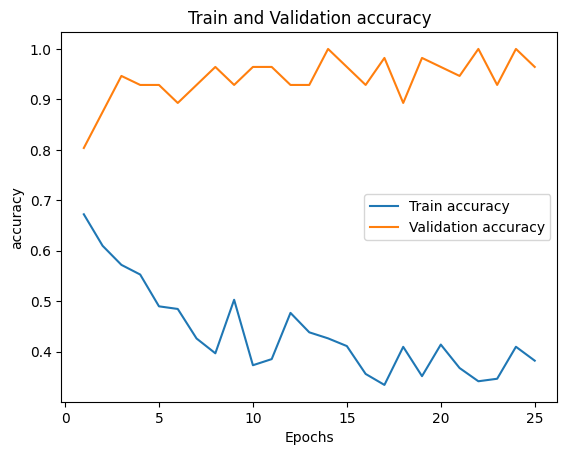

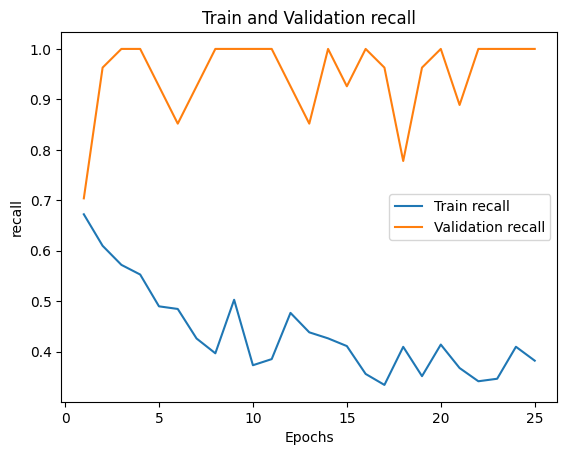

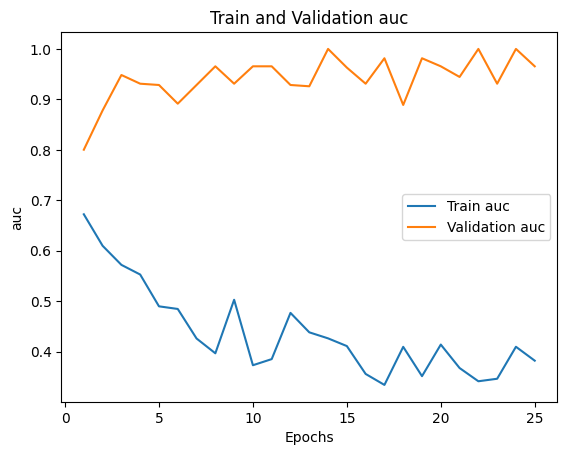

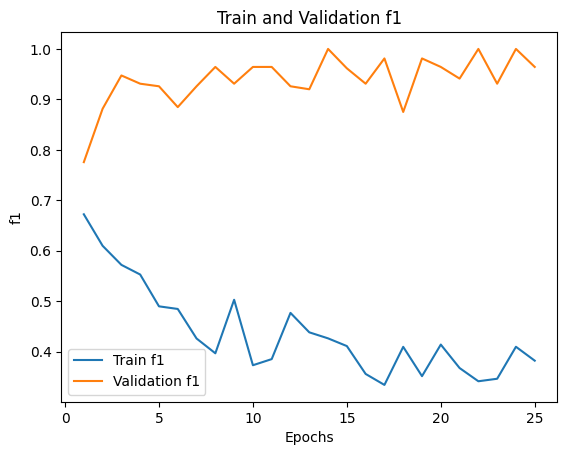

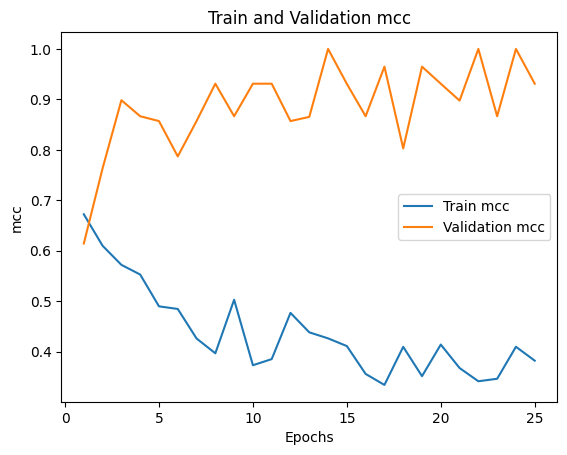

In [ ]:
import logging
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import monai
from monai.data import ImageDataset, DataLoader
from monai.transforms import EnsureChannelFirst, Compose, RandRotate90, Resize, ScaleIntensity, RepeatChannel
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, roc_curve, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.models.video import r3d_18

def load_image_paths_and_labels(data_dir, labels_csv):
    """
    Load image paths and corresponding labels from the directory and CSV file.

    Args:
    - data_dir (str): Directory containing the image files.
    - labels_csv (str): Path to the CSV file containing labels.

    Returns:
    - image_paths (List[str]): List of image file paths.
    - labels (List[int]): List of labels corresponding to the image file paths.
    """
    # Read labels CSV
    labels_df = pd.read_csv(labels_csv)

    image_paths = []
    labels = []

    for _, row in labels_df.iterrows():
        patient_id = row['PatientID']
        label = row['Cancer']
        # Find all image files for the patient
        patient_images = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith(patient_id)]
        image_paths.extend(patient_images)
        labels.extend([label] * len(patient_images))

    return image_paths, labels

def plot_and_save_metrics(epochs, train_metrics, val_metrics, metric_name, save_path):
    plt.figure()
    plt.plot(epochs, train_metrics, label=f'Train {metric_name}')
    plt.plot(epochs, val_metrics, label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'Train and Validation {metric_name}')
    plt.savefig(os.path.join(save_path, f'{metric_name}.png'))

class ResNeXt3D(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNeXt3D, self).__init__()
        self.model = r3d_18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

def main():
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    # Define data paths
    data_dir = '/content/drive/MyDrive/Praktikum/filtered_512_20P/'  # Directory containing the image files
    labels_csv = '/content/drive/MyDrive/Praktikum/labels.csv'  # Path to the CSV file containing labels

    # Number of epochs
    num_epochs = 50  # Change this value to set the number of epochs

    # Load image paths and labels
    images, labels = load_image_paths_and_labels(data_dir, labels_csv)
    labels = np.array(labels, dtype=np.int64)

    # Debugging: Print number of images and labels
    print(f"Number of images: {len(images)}, Number of labels: {len(labels)}")
    print(f"Labels distribution: {np.bincount(labels)}")

    # Define transforms
    train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), RepeatChannel(repeats=3), Resize((96, 96, 96)), RandRotate90()])
    val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), RepeatChannel(repeats=3), Resize((96, 96, 96))])

    # Split dataset into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Debugging: Print train and validation label distributions
    print(f"Train labels distribution: {np.bincount(train_labels)}")
    print(f"Validation labels distribution: {np.bincount(val_labels)}")

    # Create datasets and dataloaders
    train_ds = ImageDataset(image_files=train_images, labels=train_labels, transform=train_transforms)
    val_ds = ImageDataset(image_files=val_images, labels=val_labels, transform=val_transforms)

    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())

    # Create ResNeXt50 3D, CrossEntropyLoss and Adam optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNeXt3D(num_classes=2).to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 1e-5)

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    epoch_accuracy_values = list()
    epoch_recall_values = list()
    epoch_auc_values = list()
    epoch_f1_values = list()
    epoch_mcc_values = list()
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_preds = []
            val_true = []
            with torch.no_grad():
                num_correct = 0.0
                metric_count = 0
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    val_outputs = model(val_images)
                    val_preds.extend(val_outputs.argmax(dim=1).cpu().numpy())
                    val_true.extend(val_labels.cpu().numpy())
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                    metric_count += len(value)
                    num_correct += value.sum().item()
            accuracy = accuracy_score(val_true, val_preds)
            recall = recall_score(val_true, val_preds)
            auc = roc_auc_score(val_true, val_preds)
            f1 = f1_score(val_true, val_preds)
            mcc = matthews_corrcoef(val_true, val_preds)

            epoch_accuracy_values.append(accuracy)
            epoch_recall_values.append(recall)
            epoch_auc_values.append(auc)
            epoch_f1_values.append(f1)
            epoch_mcc_values.append(mcc)

            if accuracy > best_metric:
                best_metric = accuracy
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_classification3d_5E_RNext50_3D_512_20P.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current accuracy: {accuracy:.4f} best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", accuracy, epoch + 1)

    # Save metrics as PNG
    epochs = list(range(1, num_epochs + 1))
    metrics = {
        'accuracy': epoch_accuracy_values,
        'recall': epoch_recall_values,
        'auc': epoch_auc_values,
        'f1': epoch_f1_values,
        'mcc': epoch_mcc_values
    }
    for metric_name, metric_values in metrics.items():
        plot_and_save_metrics(epochs[:len(metric_values)], epoch_loss_values[:len(metric_values)], metric_values, metric_name, '/content/')

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()

if __name__ == "__main__":
    main()
